In [35]:
import yaml

with open("config/configs_query.yaml", "r") as f:
    data = yaml.safe_load(f)

In [36]:
import sqlite3

conn = sqlite3.connect('test_v1.db')
cursor = conn.cursor()

In [37]:
from sqlalchemy import create_engine, inspect
engine = create_engine('sqlite:///test_v1.db')
inspector = inspect(engine)

In [16]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [24]:
from typing_extensions import TypedDict

class GenQueryState(TypedDict):
    user_question: str
    tables_content: list[str]
    time_aggregation: str
    fact_table: str
    time_column: str
    whole_question: str
    main_question: str
    query: str
    result: str
    counter: int
    error: str

In [41]:
import re

def select_query_extraction(query):
    pattern = r'(SELECT.*?;)'
    matches = re.findall(pattern, query, re.DOTALL)
    if not matches:
        raise ValueError("No INSERT queries found in the provided text.")
    queries = []
    for sql in matches:
        queries.append(sql)
    return queries[0]

def checkTimeAggregation(column):
    time_unit = ""
    if ("monthly" in column):
        time_unit = "month"
        return (True, time_unit)
    elif ("hourly" in column):
        time_unit = "hour"
        return (True, time_unit)
    elif ("daily" in column or "weekdaily" in column):
        time_unit = "day"
        return (True, time_unit)
    else:
        return (False, time_unit)
    
def query_parser(query):
    print(query)
    arr = query.split("\n");
    return " ".join(arr)

def table_content_preparation(state: GenQueryState):
    tables = inspector.get_table_names()
    tables_res = []
    time_aggregation = ""
    for table_name in tables:
        columns = inspector.get_columns(table_name)
        cols = []
        isFact = "fact" in table_name
        for column in columns:
            cols.append(f"{column['name']} ({column['type']})")
            if isFact:
                (isTime, time_unit) = checkTimeAggregation(column['name'])
                if isTime:
                    state["time_column"] = column
                    time_aggregation = time_unit
        cols_str = ",".join(cols)
        cur_res = "Table " + table_name
        if isFact:
            state["time_aggregation"] = time_aggregation
            state['fact_table'] = table_name
        tables_res.append(cur_res + ": " + cols_str)
    schemas = "\n".join(tables_res)
    state["tables_content"] = schemas
    return state
    
def prepare_prompt(state: GenQueryState):
    if (state["time_aggregation"] == ""):
        main_prompt = data['etl']['question'].format(user_question=state['user_question'], table_schemas=state['tables_content'])
        whole_prompt = data['template'].format(template=main_prompt)
        state["main_question"] = main_prompt
        state["whole_question"] = whole_prompt
    else:
        main_prompt = data['time'][state['time_aggregation']].format(user_question=state['user_question'], fact_table=state["fact_table"], time_column=state['time_column'], table_schemas=state['tables_content'])
        whole_prompt = data['template'].format(template=main_prompt)
        state["main_question"] = main_prompt
        state["whole_question"] = whole_prompt
    return state

def generate_query(state: GenQueryState):
    prompt = state['whole_question']
    query = llm.invoke(prompt).content
    query = select_query_extraction(query)
    query = query_parser(query)
    state["query"] = query
    try:
        res = cursor.execute(query)
        state['result'] = res.fetchall()
        state['error'] = ""
    except sqlite3.Error as e:
        state['error'] = str(e)
        state['counter'] = state['counter'] + 1
    return state

def error_router(state: GenQueryState):
    if state['error'] == "":
        return "continue"
    else:
        if state['counter'] < 5:
            return "fix_the_query"
        else:
            return "acknowledge_error"
        
def correct_query(state: GenQueryState):
    state['whole_question'] = data['etl']['correction'].format(user_question=state['main_question'], generated_query=state['query'], error_description=state["error"])
    return state

def stop_execution(state: GenQueryState):
    state['result'] = "Could not answer your question"
    return state



In [42]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(GenQueryState)
graph.add_node("content_preparation", table_content_preparation)
graph.add_node("prompt_preparation", prepare_prompt)
graph.add_node("generate_run_query", generate_query)
graph.add_node("correct_prompt", correct_query)
graph.add_node("end_of_execution", stop_execution)

graph.add_edge(START, "content_preparation")
graph.add_edge("content_preparation", "prompt_preparation")
graph.add_edge("prompt_preparation", "generate_run_query")
graph.add_conditional_edges("generate_run_query",
    error_router,
    {
        "continue": END,
        "fix_the_query": "correct_prompt",
        "acknowledge_error": "end_of_execution"
    }
)
graph.add_edge("correct_prompt", "generate_run_query")
graph.add_edge("end_of_execution", END)

app = graph.compile()

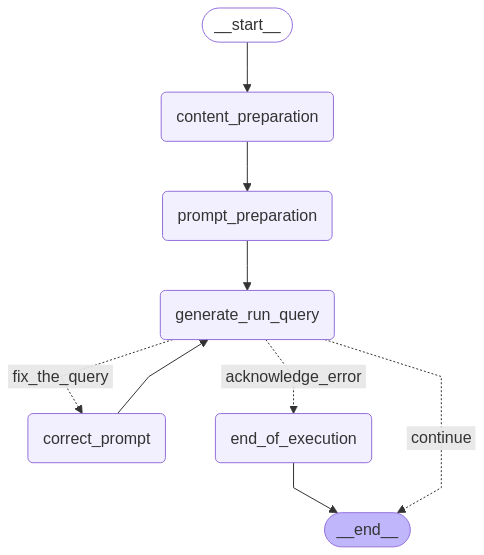

In [12]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [43]:
state = GenQueryState(user_question="How many flights?", counter=0)
result = app.invoke(state)
print(result['result'])

SELECT SUM(flight_count) AS total_flights
FROM flight_fact;
[(3,)]
